### Stanford Cars Dataset (196 classes - 8144 Train images | 8041 Test images)
Dataset link : https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset

In [1]:
import os
from glob import glob

import cv2
import random
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

In [2]:
from torch_trainer import EarlyStopping, ModelCheckpoint, Trainer, Profiler
from utils.metrics import MulticlassAccuracy

# Classification
# ---------------------------------------------------------------------------------

### 1. Create train and val splits

In [3]:
paths = {
    "train_images" : os.path.join(os.getcwd(), "datasets", "cars_train"),
    "test_images" : os.path.join(os.getcwd(), "datasets", "cars_test"),
    "train_mat" : os.path.join(os.getcwd(), "datasets", "cars_train_annos.mat"),
    "test_mat" : os.path.join(os.getcwd(), "datasets", "cars_test_annos_withlabels.mat"),
    "class_names_mat" : os.path.join(os.getcwd(), "datasets", "cars_meta.mat"),
}

In [4]:
def get_images(train_path, test_path):
    train_images = sorted(glob(os.path.join(train_path, "*")))
    test_images = sorted(glob(os.path.join(test_path, "*")))
    return train_images, test_images

def get_labels(train_path, test_path):
    train_annots = loadmat(train_path)["annotations"][0]
    test_annots = loadmat(test_path)["annotations"][0]
    
    train_labels = [(item[-2][0][0] - 1) for item in train_annots]
    test_labels = [(item[-2][0][0] - 1) for item in test_annots]
    
    return train_labels, test_labels

def get_class_labels_map(paths):
    class_names = loadmat(paths["class_names_mat"])["class_names"][0]
    
    class2Id = {item[0] : idx for idx, item in enumerate(class_names)}
    Id2class = {class_id: class_name for class_name, class_id in class2Id.items()}
    
    return class2Id, Id2class

def create_train_val(paths, split=0.9):
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    
    # read images
    train_images, test_images = get_images(paths["train_images"], paths["test_images"])
    
    # read labels
    train_labels, test_labels = get_labels(paths["train_mat"], paths["test_mat"])
    
    # concat
    images = train_images + test_images
    labels = train_labels + test_labels
    
    
    # split
    split_index = int(split * len(images))
    train_x, val_x = images[:split_index], images[split_index:]
    train_y, val_y = labels[:split_index], labels[split_index:]
    
    return (train_x, train_y), (val_x, val_y)

In [5]:
(train_x, train_y), (val_x, val_y) = create_train_val(paths, split=0.7)

print(f"Count: Train Images - {len(train_x)} | {len(train_y)}")
print(f"Count: Val Images - {len(val_x)}  | {len(val_y)}")

Count: Train Images - 7336 | 7336
Count: Val Images - 3145  | 8849


In [6]:
class2Id, Id2class = get_class_labels_map(paths)
class2Id, Id2class

({'AM General Hummer SUV 2000': 0,
  'Acura RL Sedan 2012': 1,
  'Acura TL Sedan 2012': 2,
  'Acura TL Type-S 2008': 3,
  'Acura TSX Sedan 2012': 4,
  'Acura Integra Type R 2001': 5,
  'Acura ZDX Hatchback 2012': 6,
  'Aston Martin V8 Vantage Convertible 2012': 7,
  'Aston Martin V8 Vantage Coupe 2012': 8,
  'Aston Martin Virage Convertible 2012': 9,
  'Aston Martin Virage Coupe 2012': 10,
  'Audi RS 4 Convertible 2008': 11,
  'Audi A5 Coupe 2012': 12,
  'Audi TTS Coupe 2012': 13,
  'Audi R8 Coupe 2012': 14,
  'Audi V8 Sedan 1994': 15,
  'Audi 100 Sedan 1994': 16,
  'Audi 100 Wagon 1994': 17,
  'Audi TT Hatchback 2011': 18,
  'Audi S6 Sedan 2011': 19,
  'Audi S5 Convertible 2012': 20,
  'Audi S5 Coupe 2012': 21,
  'Audi S4 Sedan 2012': 22,
  'Audi S4 Sedan 2007': 23,
  'Audi TT RS Coupe 2012': 24,
  'BMW ActiveHybrid 5 Sedan 2012': 25,
  'BMW 1 Series Convertible 2012': 26,
  'BMW 1 Series Coupe 2012': 27,
  'BMW 3 Series Sedan 2012': 28,
  'BMW 3 Series Wagon 2012': 29,
  'BMW 6 Serie

### 2. Define preprocessing fucntions and device

In [7]:
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
INPUT_CHANNEL = 3
NUM_CLASSES = len(class2Id)

total_train_len = len(train_x)
total_val_len = len(val_x)

batch_size = 6

In [8]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

def preprocess_image(image):
    x = image / 255.0
    x = x.astype(np.float32)
    x = np.moveaxis(x, -1, 0)
    return x

In [9]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, p=1.0),
    ]
)

val_transform = A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, p=1.0)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device, type(device)

(device(type='cuda'), torch.device)

### 3. Define DataLoader

In [11]:
# Inheriting from torch.utils.data.Dataset

class DatasetPreprocessor(Dataset):
    def __init__(self, inputs: list, targets: list, transform: A.Compose):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index: int):
        
        # Select the sample
        input_ID = self.inputs[index]
        target_ID = self.targets[index]

        # Read input
        x = read_image(input_ID)
        
        # transformation
        augmentations = self.transform(image=x)
        x = augmentations["image"]
        
        # preprocess
        x = preprocess_image(x)
        y = torch.tensor(target_ID, dtype=torch.long)
        
        return x, y

In [12]:
train_dataset = DatasetPreprocessor(train_x, train_y, train_transform)

train_dataloader = DataLoader(
                        dataset=train_dataset, 
                        batch_size=batch_size,
                        shuffle=True, 
                        num_workers=0,
                        pin_memory=True
                    )

val_dataset = DatasetPreprocessor(val_x, val_y, val_transform)

val_dataloader = DataLoader(
                    dataset=val_dataset, 
                    batch_size=batch_size,
                    shuffle=False, 
                    num_workers=0,
                    pin_memory=True
                )

len(train_dataloader), len(val_dataloader)

(1223, 525)

### 4. Instantiate model

In [13]:
model = efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT)
model.classifier[-1] = torch.nn.Linear(in_features=2048, out_features=NUM_CLASSES, bias=True)

In [14]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

# Profiling

In [15]:
sample_inputs = torch.randn((4, INPUT_CHANNEL, IMAGE_HEIGHT, IMAGE_WIDTH))

profiler = Profiler()
results = profiler(
    model, 
    sample_inputs, 
    devices=["cpu", "cuda"],
    n_iters=10, 
    gpu_warmup=True
)
results.to_pandas()

[INFO] : Profiling is running...
[INFO] : Performing GPU warm up with 12 iterations...
[INFO] : GPU warmup complete!
[INFO] : Completed!
[INFO] : Time taken: 20.926 seconds.


,PARAMETERS,CPU,CUDA
0,MODEL SIZE (MB),110.303,110.309
1,MODEL SIZE ON DISK (MB),110.542,110.786
2,NUM PARAMETERS (Million),28.742388,28.742388
3,SAMPLE MACs (Mega),2458.093088,2458.093088
4,SAMPLE FLOPs (Mega),4916.186176,4916.186176
5,SAMPLE AVERAGE INFERENCE TIME (Seconds),0.23075,0.01125
6,BATCH MACs (Mega),9832.372352,9832.372352
7,BATCH FLOPs (Mega),19664.744704,19664.744704
8,BATCH AVERAGE INFERENCE TIME (Seconds),0.923,0.045
9,INFERENCE BATCH SIZE,4,4


# ----------------------------------------------------------------------------------

# FP32 Training (Batch size = 48)

### Define - hyperparameters, loss, optimizers, schedulers, callbacks, metrics

In [14]:
### Define - hyperparameters, loss, metrics, optimizer, scheduler, callbacks

# hyperparameterss
lr = max_lr = 1e-4
num_epochs = 10
weight_decay = 1e-3

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=max_lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_dataloader),
    div_factor=2,
    pct_start=0.3,
    anneal_strategy='cos'
)

# callbacks
checkpoint = ModelCheckpoint(
    root_dir="experiments",
    name="fp32",
    save_best_only=True,     # saves only the best model; if set to False, saves model for every epoch
    save_model_only=True     # saves only the model; if set to False, saves model + optimizer + scheduler if provided
)
early_stopping = EarlyStopping(patience=3, verbose=True)

# metrics
metric_accuracy = MulticlassAccuracy(num_classes=NUM_CLASSES, device=device)

### Instantiate trainer and fit

In [15]:
trainer = Trainer(model, device=device)

trainer.compile(
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    scheduler_step='batch',
    metrics={
        "accuracy": metric_accuracy
    },
    callbacks=[
        checkpoint,
        early_stopping
    ],
    precision="32",
    gradient_acc=False,      
    gradient_acc_steps=8
)

In [16]:
history = trainer.fit(
    num_epochs,  
    train_dataloader,
    val_dataloader=None,
    progress_bar=True
)

[INFO] : Checkpoint directory is created at location:- E:\AI\Projects\CV_Components\CV_Utils\TrainerV2_Experimentation\experiments\fp32\runs_0


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

In [17]:
history.to_pandas()

,Epoch,Loss,Lr,Accuracy
0,1,5.250801,6.254954e-05,0.010360
1,2,4.917985,8.759888e-05,0.095692
2,3,3.970125,9.999978e-05,0.278217
3,4,2.715314,9.498486e-05,0.504771
4,5,1.676627,8.106063e-05,0.715785
5,6,1.025086,6.098496e-05,0.842285
6,7,0.661492,3.873408e-05,0.915485
7,8,0.495982,1.871504e-05,0.944793
8,9,0.413434,4.892870e-06,0.960742
9,10,0.392683,5.215099e-09,0.962923


In [18]:
history.to_csv(save_path=os.path.join(os.getcwd(), "history", "history_fp32.csv"))
history.save_history(save_path=os.path.join(os.getcwd(), "history", "history_fp32.pkl"))

[INFO] : History is saved as csv at path: E:\AI\Projects\CV_Components\CV_Utils\TrainerV2_Experimentation\history\history_fp32.csv
[INFO] : History is saved at path: E:\AI\Projects\CV_Components\CV_Utils\TrainerV2_Experimentation\history\history_fp32.pkl


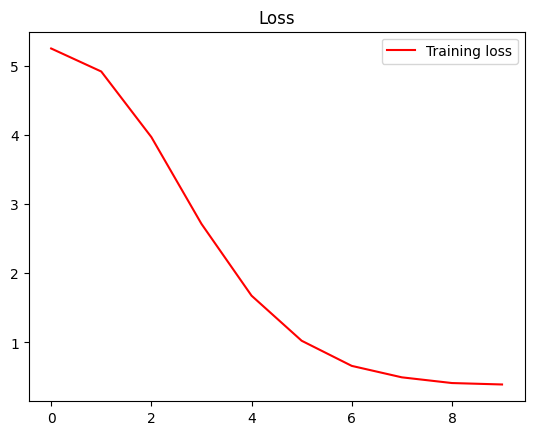

In [19]:
history.plot_loss()

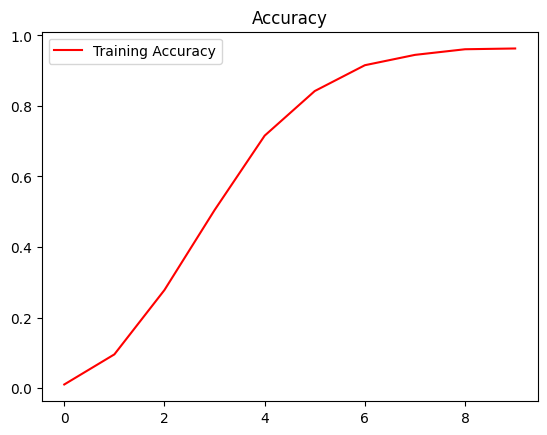

In [22]:
history.plot_metric(name="accuracy")

# ----------------------------------------------------------------------------------

# FP16 AMP Training (Batch size = 48)

### Define - hyperparameters, loss, metrics, optimizer, scheduler, callbacks

In [14]:
### Define - hyperparameters, loss, metrics, optimizer, scheduler, callbacks

# hyperparameterss
lr = max_lr = 1e-4
num_epochs = 10
weight_decay = 1e-3

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=max_lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_dataloader),
    div_factor=2,
    pct_start=0.3,
    anneal_strategy='cos'
)

# callbacks
checkpoint = ModelCheckpoint(
    root_dir="experiments",
    name="fp16_amp",
    save_best_only=True,     # saves only the best model; if set to False, saves model for every epoch
    save_model_only=True     # saves only the model; if set to False, saves model + optimizer + scheduler if provided
)
early_stopping = EarlyStopping(patience=3, verbose=True)

# metrics
metric_accuracy = MulticlassAccuracy(num_classes=NUM_CLASSES, device=device)

### Instantiate trainer and fit

In [15]:
trainer = Trainer(model, device=device)

trainer.compile(
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    metrics={
        "accuracy": metric_accuracy
    },
    callbacks=[
        checkpoint,
        early_stopping
    ],
    precision="16-mixed",
    gradient_acc=False,      
    gradient_acc_steps=8
)

INFO: Using 16-bit Automatic Mixed Precision (AMP)


[INFO] : Using 16-bit Automatic Mixed Precision (AMP)


In [16]:
history = trainer.fit(
    num_epochs,  
    train_dataloader,
    val_dataloader=None,
    progress_bar=True
)

[INFO] : Checkpoint directory is created at location:- E:\AI\Projects\CV_Components\CV_Utils\TrainerV2_Experimentation\experiments\fp16_amp\runs_0


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

In [17]:
history.to_pandas()

,Epoch,Loss,Lr,Accuracy
0,1,5.245306,6.254954e-05,0.012950
1,2,4.889082,8.759888e-05,0.112595
2,3,3.877271,9.999978e-05,0.291167
3,4,2.599349,9.498486e-05,0.515812
4,5,1.579114,8.106063e-05,0.734051
5,6,0.962732,6.098496e-05,0.851554
6,7,0.625872,3.873408e-05,0.918075
7,8,0.467049,1.871504e-05,0.945338
8,9,0.395655,4.892870e-06,0.962514
9,10,0.366873,5.215099e-09,0.965513


In [18]:
history.to_csv(save_path=os.path.join(os.getcwd(), "history", "history_fp16_amp.csv"))
history.save_history(save_path=os.path.join(os.getcwd(), "history", "history_fp16_amp.pkl"))

[INFO] : History is saved as csv at path: E:\AI\Projects\CV_Components\CV_Utils\TrainerV2_Experimentation\history\history_fp16_amp.csv
[INFO] : History is saved at path: E:\AI\Projects\CV_Components\CV_Utils\TrainerV2_Experimentation\history\history_fp16_amp.pkl


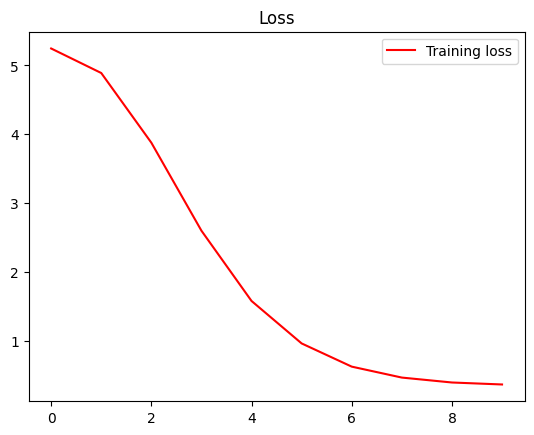

In [19]:
history.plot_loss()

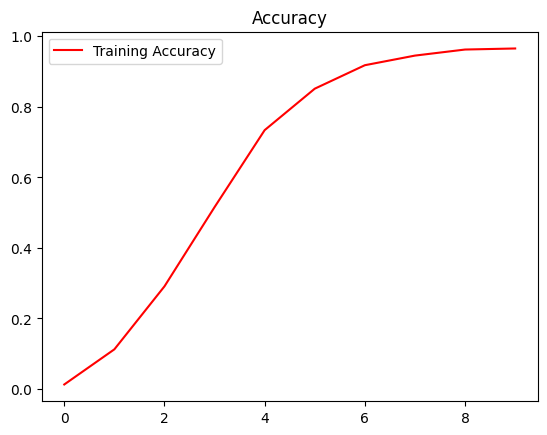

In [21]:
history.plot_metric(name="accuracy")

# ----------------------------------------------------------------------------------

# BF16 AMP Training (Batch size = 48)

### Define - hyperparameters, loss, metrics, optimizer, scheduler, callbacks

In [14]:
# hyperparameterss
lr = max_lr = 1e-4
num_epochs = 10
weight_decay = 1e-3

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=max_lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_dataloader),
    div_factor=2,
    pct_start=0.3,
    anneal_strategy='cos'
)

# callbacks
checkpoint = ModelCheckpoint(
    root_dir="experiments",
    name="bf16_amp",
    save_best_only=True,     # saves only the best model; if set to False, saves model for every epoch
    save_model_only=True     # saves only the model; if set to False, saves model + optimizer + scheduler if provided
)
early_stopping = EarlyStopping(patience=3, verbose=True)

# metrics
metric_accuracy = MulticlassAccuracy(num_classes=NUM_CLASSES, device=device)

### Instantiate trainer and fit

In [15]:
trainer = Trainer(model, device=device)

trainer.compile(
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    metrics={
        "accuracy": metric_accuracy
    },
    callbacks=[
        checkpoint,
        early_stopping
    ],
    precision="bf16-mixed",
    gradient_acc=False,      
    gradient_acc_steps=8
)

INFO: Using bfloat16 Automatic Mixed Precision (AMP)


[INFO] : Using bfloat16 Automatic Mixed Precision (AMP)


In [ ]:
# Bf16-mixed = 503 MB - x MB / 16384 MB; time = x mins

In [16]:
history = trainer.fit(
    num_epochs,  
    train_dataloader,
    val_dataloader=None,
    progress_bar=True
)

[INFO] : Checkpoint directory is created at location:- E:\AI\Projects\CV_Components\CV_Utils\TrainerV2_Experimentation\experiments\bf16_amp\runs_0


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

In [17]:
history.to_pandas()

,Epoch,Loss,Lr,Accuracy
0,1,5.253920,6.254954e-05,0.010496
1,2,4.954944,8.759888e-05,0.097328
2,3,3.939320,9.999978e-05,0.292530
3,4,2.535197,9.498486e-05,0.546483
4,5,1.495231,8.106063e-05,0.750409
5,6,0.894813,6.098496e-05,0.866140
6,7,0.575359,3.873408e-05,0.924891
7,8,0.424485,1.871504e-05,0.952563
8,9,0.364467,4.892870e-06,0.964967
9,10,0.341003,5.215099e-09,0.971374


In [ ]:
history.to_csv(save_path=os.path.join(os.getcwd(), "history", "history_bf16_amp.csv"))
history.save_history(save_path=os.path.join(os.getcwd(), "history", "history_bf16_amp.pkl"))

In [ ]:
history.plot_loss()

In [ ]:
history.plot_metrics()

# ----------------------------------------------------------------------------------

# FP16 AMP Training (Batch size = 6 + Gradient Accumulation steps = 8)

### Define - hyperparameters, loss, metrics, optimizer, scheduler, callbacks

In [14]:
gradient_acc_steps = 8
if len(train_dataloader) % gradient_acc_steps == 0:
    scheduler_steps_per_epoch = int(len(train_dataloader) / gradient_acc_steps)
else:
    scheduler_steps_per_epoch = int(len(train_dataloader) / gradient_acc_steps) + 1

# hyperparameterss
lr = max_lr = 1e-4
num_epochs = 10
weight_decay = 1e-3

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=max_lr,
    epochs=num_epochs,
    steps_per_epoch=scheduler_steps_per_epoch,
    div_factor=2,
    pct_start=0.3,
    anneal_strategy='cos'
)

# callbacks
checkpoint = ModelCheckpoint(
    root_dir="experiments",
    name="fp16_amp_grad_acc",
    save_best_only=True,     # saves only the best model; if set to False, saves model for every epoch
    save_model_only=True     # saves only the model; if set to False, saves model + optimizer + scheduler if provided
)
early_stopping = EarlyStopping(patience=3, verbose=True)

# metrics
metric_accuracy = MulticlassAccuracy(num_classes=NUM_CLASSES, device=device)

### Instantiate trainer and fit

In [15]:
trainer = Trainer(model, device=device)

trainer.compile(
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    metrics={
        "accuracy": metric_accuracy
    },
    callbacks=[
        checkpoint,
        early_stopping
    ],
    precision="16-mixed",
    gradient_acc=True,      
    gradient_acc_steps=gradient_acc_steps
)

INFO: Using 16-bit Automatic Mixed Precision (AMP)


[INFO] : Using 16-bit Automatic Mixed Precision (AMP)


In [ ]:
# Bf16-mixed Grad Acc= 639 MB - x MB / 16384 MB; time = x mins

In [16]:
history = trainer.fit(
    num_epochs,  
    train_dataloader,
    val_dataloader=None,
    progress_bar=True
)

[INFO] : Checkpoint directory is created at location:- E:\AI\Projects\CV_Components\CV_Utils\TrainerV2_Experimentation\experiments\fp16_amp_grad_acc\runs_0


  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

In [17]:
history.to_pandas()

,Epoch,Loss,Lr,Accuracy
0,1,5.249320,6.250618e-05,0.010632
1,2,4.950788,8.751236e-05,0.072519
2,3,4.195994,1.000000e-04,0.174209
3,4,3.278093,9.504073e-05,0.329880
4,5,2.484301,8.116108e-05,0.518130
5,6,1.888163,6.111010e-05,0.656352
6,7,1.496513,3.885912e-05,0.737868
7,8,1.258154,1.881523e-05,0.793893
8,9,1.134190,4.948351e-06,0.827017
9,10,1.092622,5.003366e-09,0.832879


In [18]:
history.to_csv(save_path=os.path.join(os.getcwd(), "history", "history_bf16_amp_grad_acc.csv"))
history.save_history(save_path=os.path.join(os.getcwd(), "history", "history_bf16_amp_grad_acc.pkl"))

[INFO] : History is saved as csv at path: E:\AI\Projects\CV_Components\CV_Utils\TrainerV2_Experimentation\history\history_bf16_amp_grad_acc.csv
[INFO] : History is saved at path: E:\AI\Projects\CV_Components\CV_Utils\TrainerV2_Experimentation\history\history_bf16_amp_grad_acc.pkl


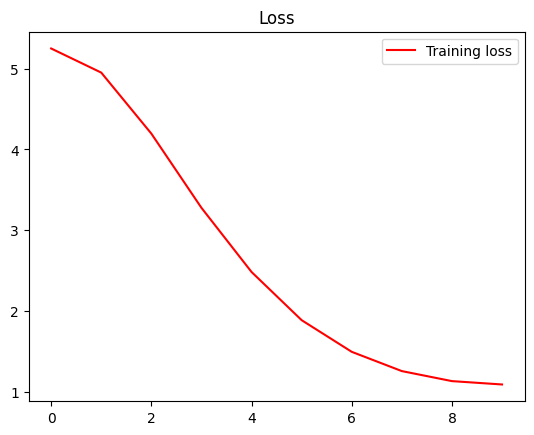

In [19]:
history.plot_loss()

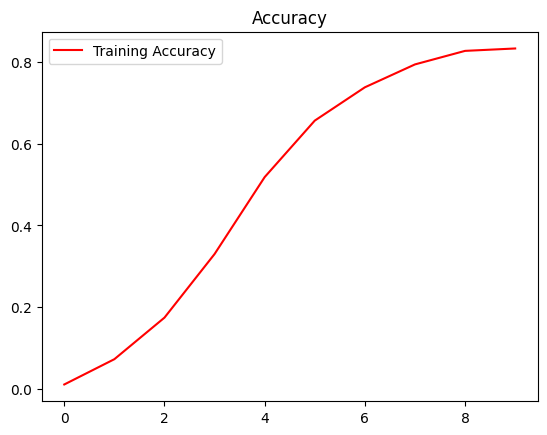

In [21]:
history.plot_metric(name="accuracy")